# Deep learning sur la finance 

## Martín Pasche

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import seaborn as sns
import os

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.layers import Input

# only grow GPU memory when needed
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)


from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

data_folder = os.path.join("data")

In [4]:
T = 100
number_H = 10
M_train = 10000
M_test = 1000
J = M_train // number_H  #number of time series per parameter choice


In [5]:
H_values = np.linspace(0.0000001, 0.9999999, number_H)

In [6]:
import fbm

try:
    X_train = joblib.load(os.path.join(data_folder, "X_train.pkl"))
    Y_train = joblib.load(os.path.join(data_folder, "Y_train.pkl"))
except Exception as e:
    X_train = np.zeros((M_train, T))
    Y_train = np.zeros((M_train, 1))

    for i in range(J):
        for j, h in enumerate(H_values):
            motion = fbm.fbm(T - 1, h)
            index = i * number_H + j
            X_train[index, ] = motion
            Y_train[index] = h

In [7]:
num_H = 100
H_values = np.linspace(0.01, 0.99, num_H)

In [8]:
try:
    X_test = joblib.load(os.path.join(data_folder, "X_test.pkl"))
    Y_test = joblib.load(os.path.join(data_folder, "Y_test.pkl"))
except Exception as e:
    X_test = np.zeros((M_test, T))
    Y_test = np.zeros((M_test, 1))

    for i in range(M_test // num_H):
        for j, h in enumerate(H_values):
            motion = fbm.fbm(T - 1, h)
            index = i * num_H + j
            X_test[index, ] = motion
            Y_test[index] = h

<Axes: >

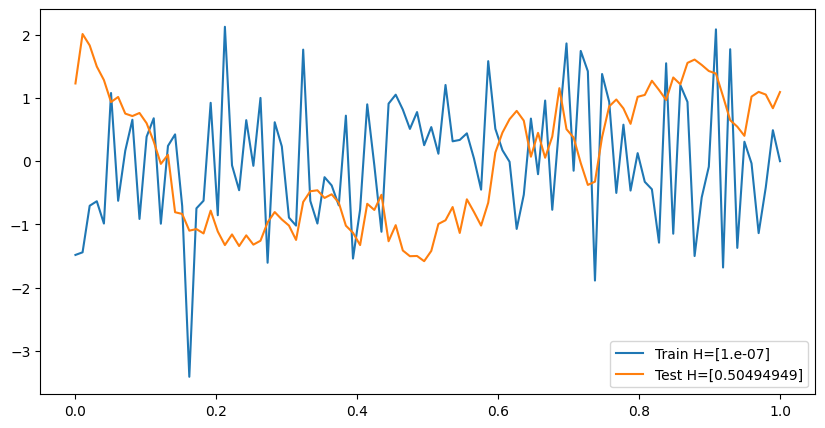

In [9]:
from sklearn.preprocessing import scale

X_train = scale(X_train, axis=1)
X_test = scale(X_test, axis=1)

plt.figure(figsize=(10, 5))
idx = 50
sns.lineplot(x=np.linspace(0, 1, T), y=X_train[idx, ], label=f"Train H={Y_train[idx]}")
sns.lineplot(x=np.linspace(0, 1, T), y=X_test[idx, ], label=f"Test H={Y_test[idx]}")

In [10]:
joblib.dump(X_train, os.path.join(data_folder, 'X_train.pkl'))
joblib.dump(X_test, os.path.join(data_folder, 'X_test.pkl'))
joblib.dump(Y_train, os.path.join(data_folder, 'Y_train.pkl'))
joblib.dump(Y_test, os.path.join(data_folder, 'Y_test.pkl'))

['data\\Y_test.pkl']

# Model 

In [11]:

model_DNN = Sequential()
model_DNN.add(Input(shape=(T,)))
model_DNN.add(Dense(75, activation='relu'))
model_DNN.add(Dense(50, activation='relu'))
model_DNN.add(Dense(25, activation='relu'))
model_DNN.add(Dense(25, activation='relu'))
model_DNN.add(Dense(1, activation='linear'))

model_DNN.compile(loss="mse", optimizer="adam")
model_DNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 75)             │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,326 (52.05 KB)

 Trainable params: 13,326 (52.05 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model_DNN.fit(X_train, Y_train, epochs = 1000, batch_size=64, validation_split=0.2, callbacks=[es])

Epoch 1/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1064 - val_loss: 0.0287
Epoch 2/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269 - val_loss: 0.0237
Epoch 3/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0218 - val_loss: 0.0213
Epoch 4/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - val_loss: 0.0201
Epoch 5/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 - val_loss: 0.0182
Epoch 6/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0174
Epoch 7/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.0173
Epoch 8/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - val_loss: 0.0170
Epoch 9/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0165
Epoch 10/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0163
Epoch 11/1000
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0170
Epoch 12/1000
125/125 ━━━━━━━━

In [13]:
Y_pred_Dense = model_DNN.predict(X_test).flatten() #(1000, 1) -> (1000,)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [14]:
df = pd.DataFrame({'Y_test': Y_test.flatten(), 'Y_pred_Dense': Y_pred_Dense})

Text(0.5, 1.0, 'Bias vs H')

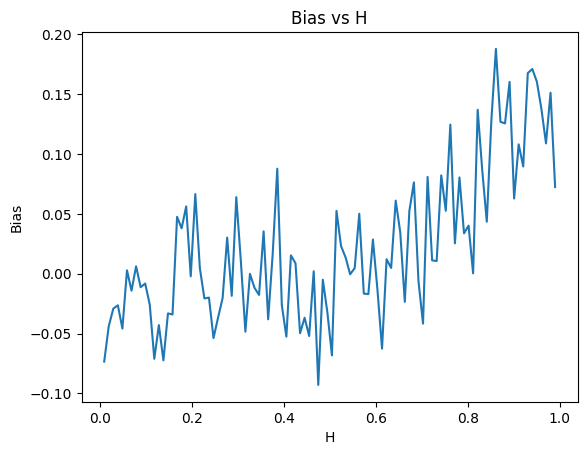

In [15]:
df['bias'] = df['Y_test'] - df['Y_pred_Dense']
bias_dense = df.groupby('Y_test')['bias'].mean()
plt.plot(bias_dense.index, bias_dense.values, label='Dense')
plt.xlabel('H')
plt.ylabel('Bias')
plt.title("Bias vs H")

Mean Squared Error: 0.017418082803487778
Mean Absolute Error: 0.10321452468633652


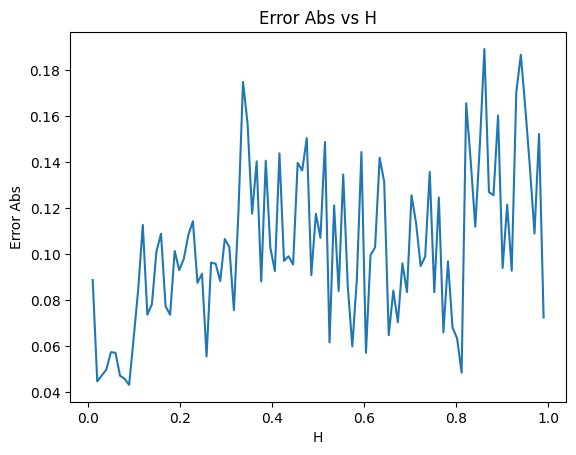

In [16]:
df['error absolute'] = abs( df['Y_test'] - df['Y_pred_Dense'])
error_dense = df.groupby('Y_test')['error absolute'].mean()
plt.plot(error_dense.index, error_dense.values, label='Dense')
plt.xlabel('H')
plt.ylabel('Error Abs')
plt.title("Error Abs vs H")

print(f"Mean Squared Error: {MeanSquaredError()(Y_test, Y_pred_Dense)}")
print(f"Mean Absolute Error: {MeanAbsoluteError()(Y_test, Y_pred_Dense)}")

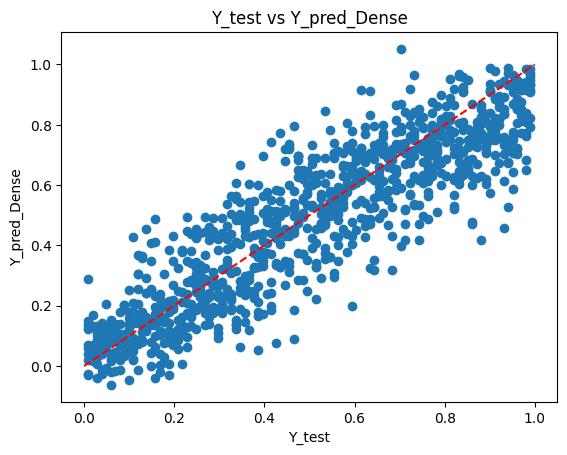

In [17]:
plt.plot(df['Y_test'], df['Y_pred_Dense'], 'o')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Y_test')
plt.ylabel('Y_pred_Dense')
plt.title('Y_test vs Y_pred_Dense')
plt.show()

# CNN

In [18]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense

def build_CNN(window_size, kernel_sizes=(20,20,20),  nb_input_series=1, nb_outputs=1, 
                                   nb_kernels=(32,64,128),
                                  activation_type="relu"):
    model = Sequential()
    model.add(Input(shape=(window_size, nb_input_series)))
    
    def small_layer(kernel_size, filter_size, pool_size, drop_out):
        model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation=activation_type))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(drop_out))
        return model
    
    model = small_layer(kernel_sizes[0], nb_kernels[0], 2, 0.25)
    model = small_layer(kernel_sizes[1], nb_kernels[1], 2, 0.25)
    model = small_layer(kernel_sizes[2], nb_kernels[2], 2, 0.4)
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(nb_outputs, activation='linear'))
    return model


model_CNN = build_CNN(window_size=T, kernel_sizes=(3, 3, 3), nb_kernels=(32, 64, 128) , nb_input_series=1, nb_outputs=1)
model_CNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 47, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,137 (762.25 KB)

 Trainable params: 195,137 (762.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
X_train_CNN = np.expand_dims(X_train, axis=2)
Y_train_CNN = np.expand_dims(Y_train, axis=1)
X_train_CNN.shape, Y_train_CNN.shape

((10000, 100, 1), (10000, 1, 1))

In [20]:
model_CNN.compile(loss="mse", optimizer="adam")
model_CNN.fit(X_train_CNN, Y_train, epochs = 1000, batch_size=32, validation_split=0.2, callbacks=[es], verbose=1)

Epoch 1/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0698 - val_loss: 0.0407
Epoch 2/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0143 - val_loss: 0.0264
Epoch 3/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0114 - val_loss: 0.0171
Epoch 4/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - val_loss: 0.0112
Epoch 5/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 6/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0078 - val_loss: 0.0111
Epoch 7/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 8/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 9/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 10/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 11/1000
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 12/1000
250/250 ━━━━━━━━

In [21]:
Y_pred_cnn = model_CNN.predict(np.expand_dims(X_test, axis=2)).flatten()
df_cnn = pd.DataFrame({'Y_test': Y_test.flatten(), 'Y_pred_cnn': Y_pred_cnn})
df_cnn['bias'] = df_cnn['Y_test'] - df_cnn['Y_pred_cnn']
df_cnn['error absolute'] = abs( df_cnn['Y_test'] - df_cnn['Y_pred_cnn'])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<Axes: title={'center': 'CNN bias'}, xlabel='Y_test', ylabel='Bias'>

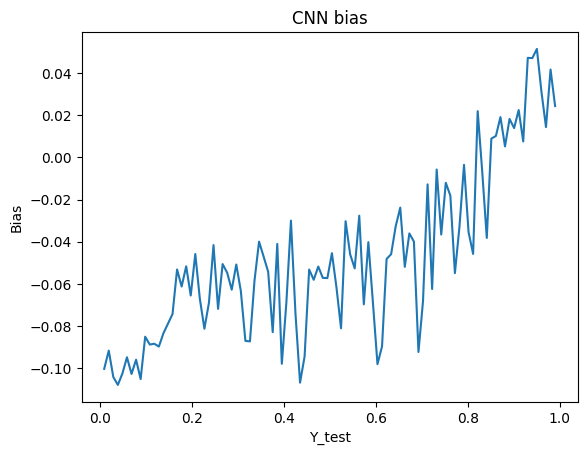

In [22]:
bias_cnn = df_cnn.groupby('Y_test')['bias'].mean()
bias_cnn.plot(title="CNN bias", ylabel="Bias")

Mean Squared Error: 0.0070060063153505325
Mean Absolute Error: 0.06920234858989716


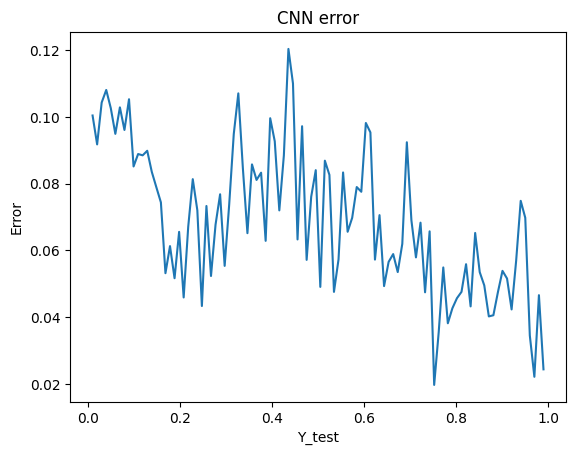

In [23]:
error_cnn = df_cnn.groupby('Y_test')['error absolute'].mean()
error_cnn.plot(title="CNN error", ylabel="Error")

print(f"Mean Squared Error: {MeanSquaredError()(Y_test, Y_pred_cnn)}")
print(f"Mean Absolute Error: {MeanAbsoluteError()(Y_test, Y_pred_cnn)}")

### Comparation entre CNN et DNN

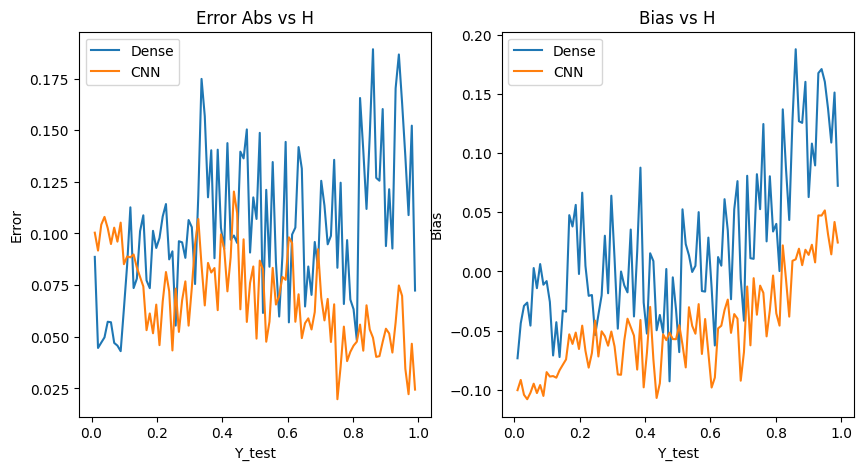

In [24]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
error_dense.plot(label="Dense", ylabel="Error")
error_cnn.plot(label="CNN", ylabel="Error")
plt.title("Error Abs vs H")
plt.legend()

plt.subplot(1, 2, 2)
bias_dense.plot(label="Dense", ylabel="Bias")
bias_cnn.plot(label="CNN", ylabel="Bias")
plt.title("Bias vs H")
plt.legend()

## Combining CNN and RNN

### Average output

In [25]:
Y_pred_mean = (Y_pred_Dense + Y_pred_cnn) / 2
df_mean = pd.DataFrame({'Y_test': Y_test.flatten(), 'Y_pred_cnn': Y_pred_mean})
df_mean['bias'] = df_mean['Y_test'] - df_mean['Y_pred_cnn']
df_mean['error absolute'] = abs( df_mean['Y_test'] - df_mean['Y_pred_cnn'])
bias_mean = df_mean.groupby('Y_test')['bias'].mean()
error_mean = df_mean.groupby('Y_test')['error absolute'].mean()

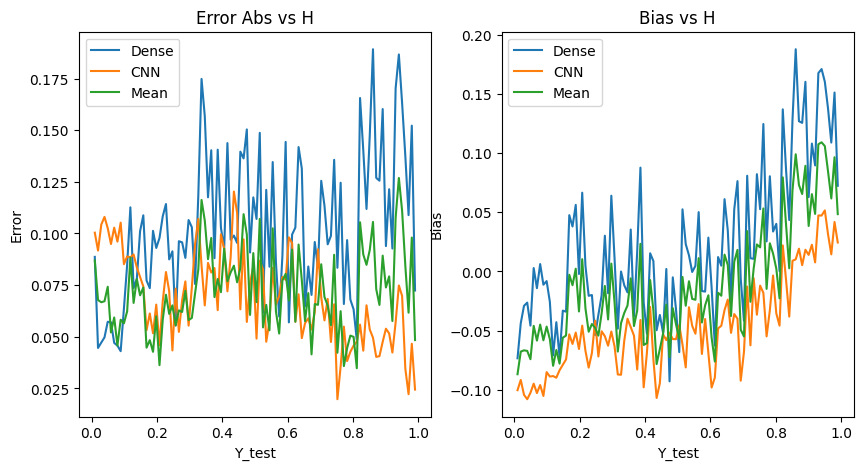

In [26]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
error_dense.plot(label="Dense", ylabel="Error")
error_cnn.plot(label="CNN", ylabel="Error")
error_mean.plot(label="Mean", ylabel="Error")
plt.title("Error Abs vs H")
plt.legend()

plt.subplot(1, 2, 2)
bias_dense.plot(label="Dense", ylabel="Bias")
bias_cnn.plot(label="CNN", ylabel="Bias")
bias_mean.plot(label="Mean", ylabel="Bias")
plt.title("Bias vs H")
plt.legend()

### Using KFolds and stacking models to improve performance

In [27]:
from sklearn.model_selection import KFold

def create_dnn():
    model = Sequential()
    model.add(Input(shape=(T,)))
    model.add(Dense(75, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss="mse", optimizer="adam")
    return model

In [28]:

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for out-of-sample predictions
oof_predictions1 = np.zeros((X_train.shape[0], 1))  # For model1
oof_predictions2 = np.zeros((X_train.shape[0], 1))  # For model2

# Base models
for train_index, val_index in kf.split(X_train):
    # Split data into training and validation
    x_fold_train, x_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = Y_train[train_index], Y_train[val_index]

    # Define and train model1
    model1 = create_dnn()
    model1.fit(x_fold_train, y_fold_train, epochs=100, verbose=0, callbacks=[es], batch_size=32)

    # Predict on the validation fold for model1
    oof_predictions1[val_index] = model1.predict(x_fold_val)

    # Define and train model2
    model2 = build_CNN(window_size=T, kernel_sizes=(3, 3, 3), nb_kernels=(32, 64, 128) , nb_input_series=1, nb_outputs=1)
    model2.compile(optimizer='adam', loss='mse')
    x_fold_train_CNN = np.expand_dims(x_fold_train, axis=2)
    x_fold_val_CNN = np.expand_dims(x_fold_val, axis=2)
    y_fold_train_CNN = np.expand_dims(y_fold_train, axis=1)
    y_fold_val_CNN = np.expand_dims(y_fold_val, axis=1)
    model2.fit(x_fold_train_CNN, y_fold_train_CNN, epochs=100, verbose=0, callbacks=[es], batch_size=32)

    # Predict on the validation fold for model2
    oof_predictions2[val_index] = model2.predict(x_fold_val_CNN)

# Stacked inputs for the meta-model
stacked_inputs = np.hstack([oof_predictions1, oof_predictions2])  # Shape: (num_samples, 2)

c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### Train meta model

In [29]:
meta_model = Sequential([
    Input(shape=(2,)),
    Dense(4, activation='relu'),
    Dense(1, activation='linear')
])
meta_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
meta_model.fit(stacked_inputs, Y_train, epochs=100, verbose=0, callbacks=[es], batch_size=32)

c:\Users\Marti\OneDrive\Escritorio\DL Finance\FinanceEnv\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


### Evaluate meta model

In [30]:
y_pred_dnn = model_DNN.predict(X_test)
y_pred_cnn = model_CNN.predict(np.expand_dims(X_test, axis=2))

# Create test input for the meta-model
test_stacked_inputs = np.hstack([y_pred_dnn, y_pred_cnn])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [31]:
Y_pred_meta = meta_model.predict(test_stacked_inputs)
Y_pred_meta = np.where(Y_pred_meta < 0, 0, Y_pred_meta)
Y_pred_meta = np.where(Y_pred_meta > 1, 1, Y_pred_meta)

print(f"Mean Squared Error: {MeanSquaredError()(Y_test, Y_pred_meta)}")
print(f"Mean Absolute Error: {MeanAbsoluteError()(Y_test, Y_pred_meta)}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error: 0.0046121468767523766
Mean Absolute Error: 0.05213191732764244


In [32]:
Y_pred_meta = Y_pred_meta.flatten()
df_meta = pd.DataFrame({'Y_test': Y_test.flatten(), 'Y_pred_cnn': Y_pred_meta})
df_meta['bias'] = df_meta['Y_test'] - df_meta['Y_pred_cnn']
df_meta['error absolute'] = abs( df_meta['Y_test'] - df_meta['Y_pred_cnn'])
bias_meta = df_meta.groupby('Y_test')['bias'].mean()
error_meta = df_meta.groupby('Y_test')['error absolute'].mean()

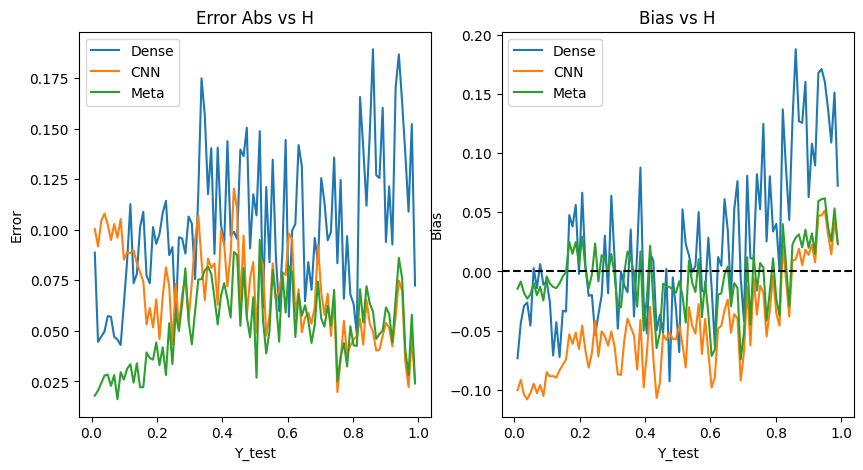

In [33]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
error_dense.plot(label="Dense", ylabel="Error")
error_cnn.plot(label="CNN", ylabel="Error")
error_meta.plot(label="Meta", ylabel="Error")
plt.title("Error Abs vs H")
plt.legend()

plt.subplot(1, 2, 2)
bias_dense.plot(label="Dense", ylabel="Bias")
bias_cnn.plot(label="CNN", ylabel="Bias")
bias_meta.plot(label="Meta", ylabel="Bias")
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Bias vs H")
plt.legend()

## How to be more robust to outliers

- One way would be to use another loss functions.
- Use regularization terms in the model, like L1 and L2 techniques, that can help to reduce overfitting and be more robust.
- Combining models smooth out outliers predictions
